<a href="https://colab.research.google.com/github/quaydragon/EquippingCharacters/blob/main/Fantasy_Football_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fantasy Football Model to Win Office Money
### No football knowledge required, only a need to win. 


Bayesian Modeling is all about becoming an expert in your domain and using that knowledge to create accurate models which could not be accomplished by your out of the box supervised algorithm. 

My partner, is an expert on fantasy football. As a fan, he competes with his friend's (enemies?) for a pot of money and gloating rights. I, however, do not compete with my friends for fantasy football clout. If you are anything like me, you have spent countless football seasons not participating in office fantasy competition because you would lose that precious 10 dollar buyin (that could maybe be a half the price of lunch). 

Do not fret! This year I have saved you. We are going to get the money. No one is going to expect us. From conversations with my partner and a class on bayesian modeling, I have finally learned the difference between a running back and a wide reciever (don't ask me in a month though). 



## How does this model work?

This model will be using the attempts that each player makes to predict the number of points that player will get for your fantasy football team. 

We will then use attempts to model touchdowns, yards, and fumbles. These models will be use to calculate points using the following equation:

points = 6TD + 0.1Yards - 2*Fumbles

##Attempts

The key driver of this algorithm comes from its ability to model attempts. There are several initial steps we must take to process and bucket the data. 

###Processing Steps

1. Grab the data. Originally from the NFL website. 
2. Drop those NAs. We don't want them. 
3. Capture the growth of the player.
4. Bucket the player based upon how good they are about making attempts. 


Making a lot of attempts says a few things. Firstly, your team must trust you because they are choosing to pass the ball. Secondly, you must trust your abilities. Confidence is key. We came up with 10 different levels of play. The current attempts that player had was multiplied by the growth rate the in attempts the player had experienced in recent years. Therefore capturing a more holistic representation of that player. 

We capture growth by the number of games the player plays in year over year and the number of attempts that player takes. 


In [131]:
# Importing Needed things!

import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import pandas

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")


In [132]:
# Getting the data

data = pandas.read_csv("https://raw.githubusercontent.com/iandardik/CS7290_project/master/data.csv")
data = data.dropna()

In [133]:
# Calculating the growth of the player
def growth(row):
  last_year = row['Year'] - 1
  ID = row['ID']
  old = data[data.ID == ID]
  old = old[old.Year == last_year]

  if len(old) > 0:
    delta = int(row['Attempts']) / int(old['Attempts'])
    return delta

  else:
    return None

data['growth_delta'] = data.apply(growth, axis=1)

data = data.dropna()


## game play is very important because it can signify injury or progression in the career

## take the mean games played by all players
## the level above or below mean should be the multiple

game_mean = data['Games'].mean()

def game_play_growth(row):
  last_year = row['Year'] - 1
  ID = row['ID']
  old = data[data.ID == ID]
  old = old[old.Year == last_year]

  if len(old) > 0:
    delta = int(row['Games']) / game_mean
    return delta

  else:
    return None

data['game_play_growth'] = data.apply(game_play_growth, axis=1)

data = data.dropna()

In [134]:
## Bucketing the players

def label_player(row):
  attempts = row['Attempts']

  delta = row['growth_delta']
  game_delta = row['game_play_growth']

  predicted = attempts

  if delta != None and attempts < 375:
      predicted = attempts * delta * game_delta
      # represents diminishinng returns do better
      
      if predicted > 420:
        predicted = attempts * delta
      if predicted > 420:
        predicted = attempts + 10


  
  if predicted < 25 and predicted > 0:
    
    return 0
  elif predicted < 50:
    return 1
  elif predicted < 100:
    return 2
  elif predicted < 150:
    return 3
  elif predicted < 200:
    return 4
  elif predicted < 250:
    return 5
  elif predicted < 300:
    return 6
  elif predicted < 350:
    return 7
  elif predicted < 400:
    
    return 8
  else:
    return 9


data['player_rank'] = data.apply(label_player, axis=1)

## Attempts Model


The following model creates different distributions for each ranking of player. Below the highest rank of 9 we are using a bounded normal distribution which cannot go below 0. This is because a player cannot actually have negative attempts. 

For the highest ranking players we are using a Student-T distribution because it has wider tails which is what we need to capture the larger range of performance upper echelon players have from season to season. 


You will see that the model below outputs the convergence checks of two chains from our Metropolis-Hastings sampling algorithm. These are converging nicely.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [highest_attempts, nu, 400_attempts, 350_attempts, 300_attempts, 250_attempts, 200_attempts, 150_attempts, 100_attempts, 50_attempts, 25_attempts]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 18 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


mean      sd   hdi_3%  hdi_97%
highest_attempts  404.668   9.839  391.844  420.569
25_attempts        12.815   7.853    0.082   26.620
50_attempts        44.894  10.014   26.785   64.306
100_attempts       75.072   9.975   56.928   94.422
150_attempts      124.719  10.335  105.252  144.027
200_attempts      175.080   9.844  157.054  193.691
250_attempts      225.003  10.108  207.066  244.076
300_attempts      275.131   9.939  258.117  295.279
350_attempts      324.833  10.009  305.278  342.843
400_attempts      374.869  10.098  356.356  393.732
nu                 10.239  10.180    0.024   27.225

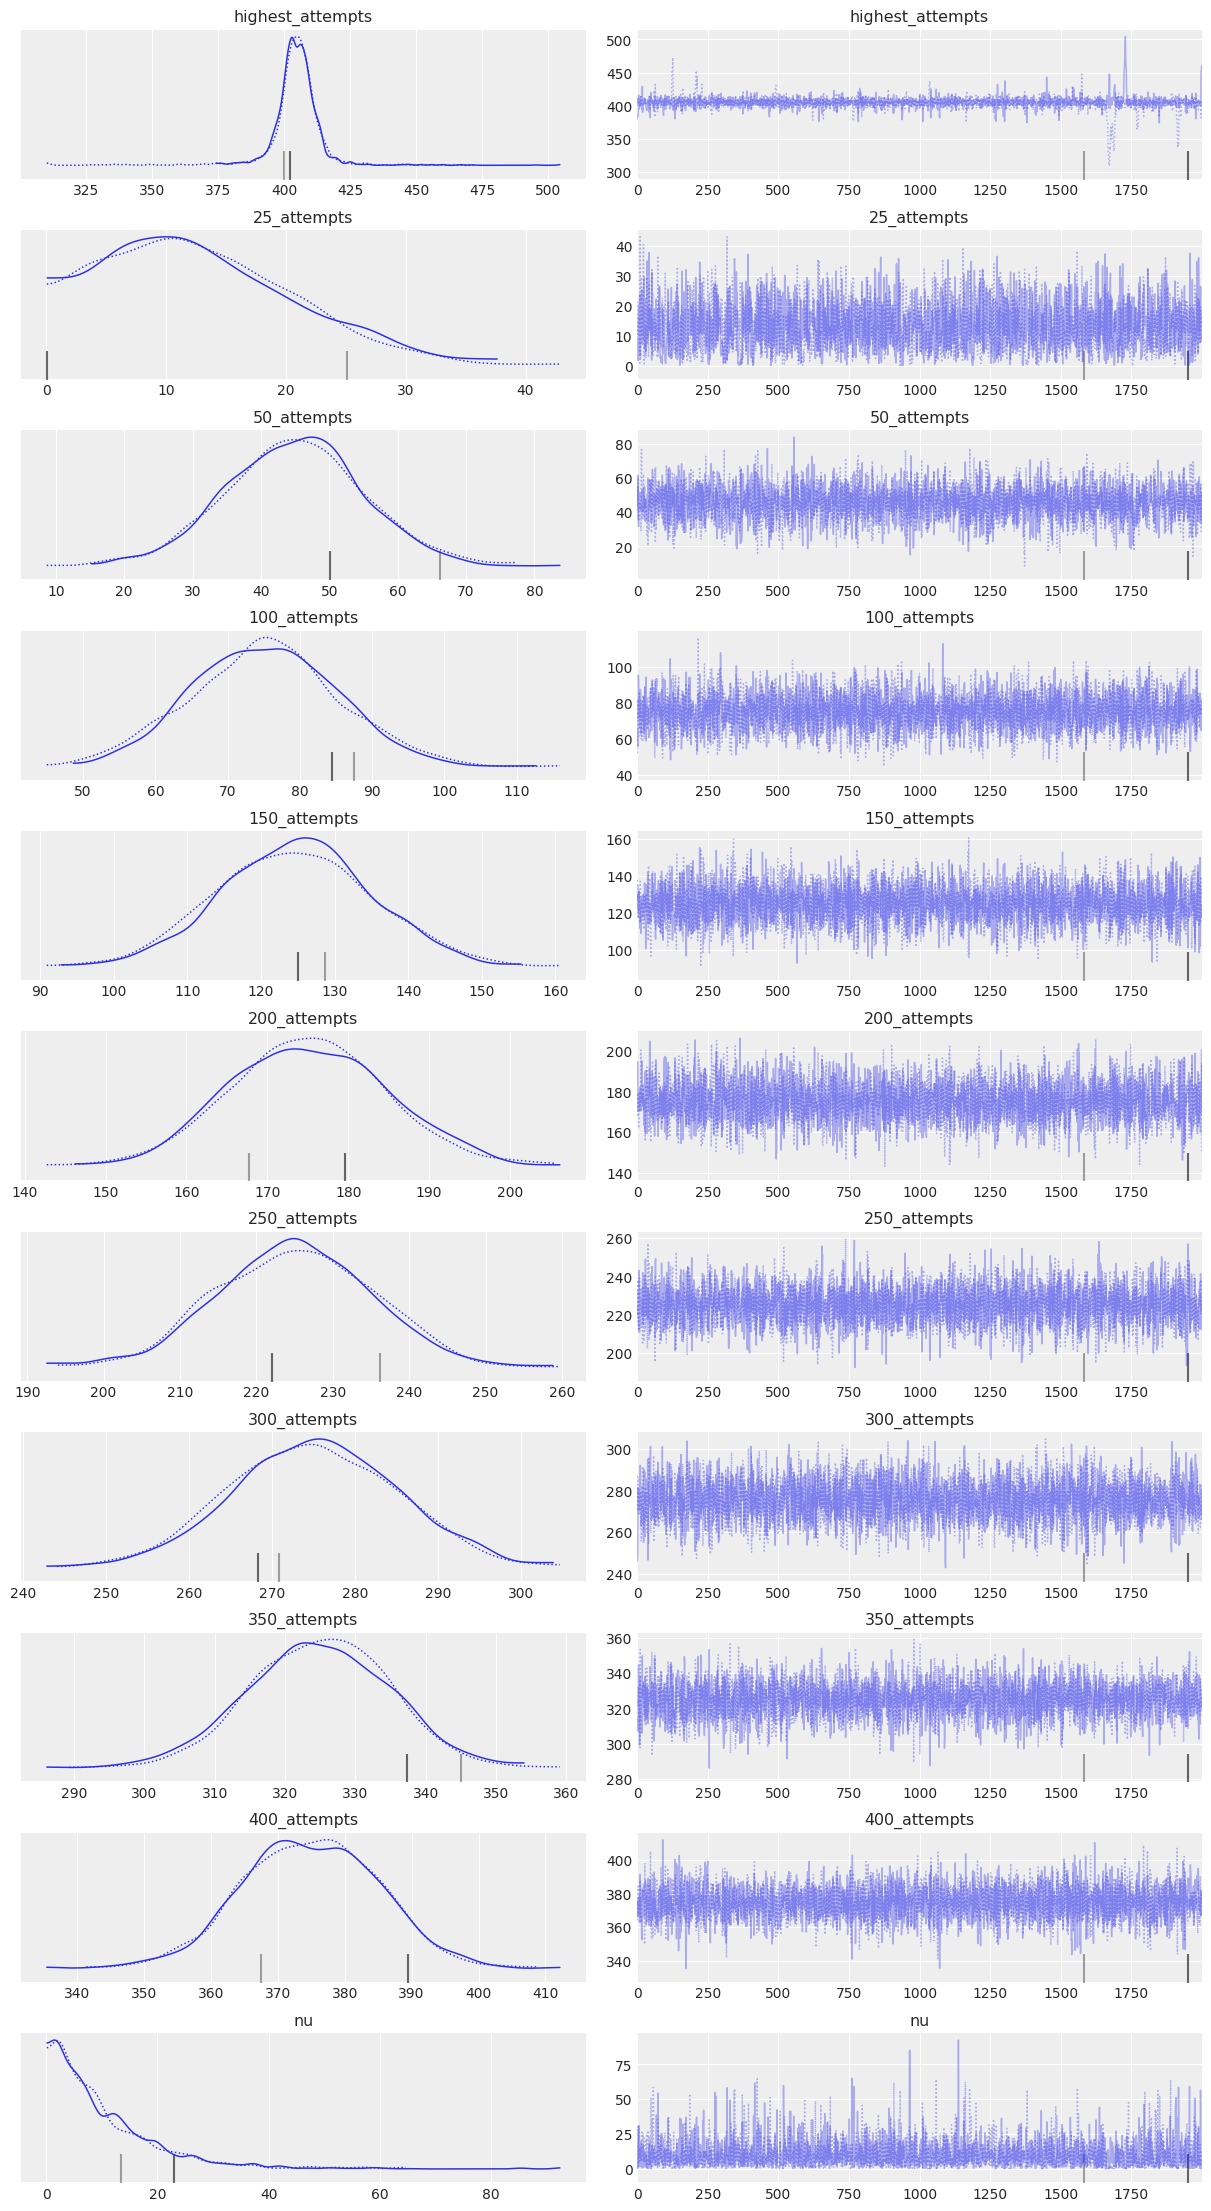

In [135]:
### attempts model off of player rank



with pm.Model() as attempts_proper:

  BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
  #0 0 -25
  mu = 10
  sigma = 10

  d = BoundedNormal("25_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #1 25 - 50
  mu = 45
  sigma= 10


  d = BoundedNormal("50_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #2 50 - 100
  mu = 75
  sigma = 10
  d = BoundedNormal("100_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #3 100 - 150
  mu = 125
  sigma = 10
  d = BoundedNormal("150_attempts",
                       mu=mu,
                       sigma= sigma,
                       )



  #4 150 - 200

  mu = 175
  sigma = 10
  d = BoundedNormal("200_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #5 200 - 250

  mu = 225
  sigma = 10

  d = BoundedNormal("250_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #6 250 - 300

  mu = 275
  sigma = 10

  d = BoundedNormal("300_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #7 300 - 350

  mu = 325
  sigma = 10
  d = BoundedNormal("350_attempts",
                       mu=mu,
                       sigma= sigma,
                       )


  #8 350 - 400

  mu = 375
  sigma = 10
  d = BoundedNormal("400_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #9 400 +

  mu = 405
  sigma = 5
  nu = pm.Exponential('nu', 1./10, testval = 5.)

  d = pm.StudentT("highest_attempts",
                       mu=mu,
                       sigma= sigma, nu=nu)
  step = pm.Metropolis()
  trace_proper_attempts = pm.sample(2000, chains=2, return_inferencedata=True) #, step=step)
  az.plot_trace(trace_proper_attempts)

az.summary(trace_proper_attempts, kind="stats")                       

## Prior Checks

It is important to check that your priors are fitting the actual distribution. Below these normalized histograms show if our priors are able to capture the distribution of attempts from our 10 different player ranking subsets. 


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


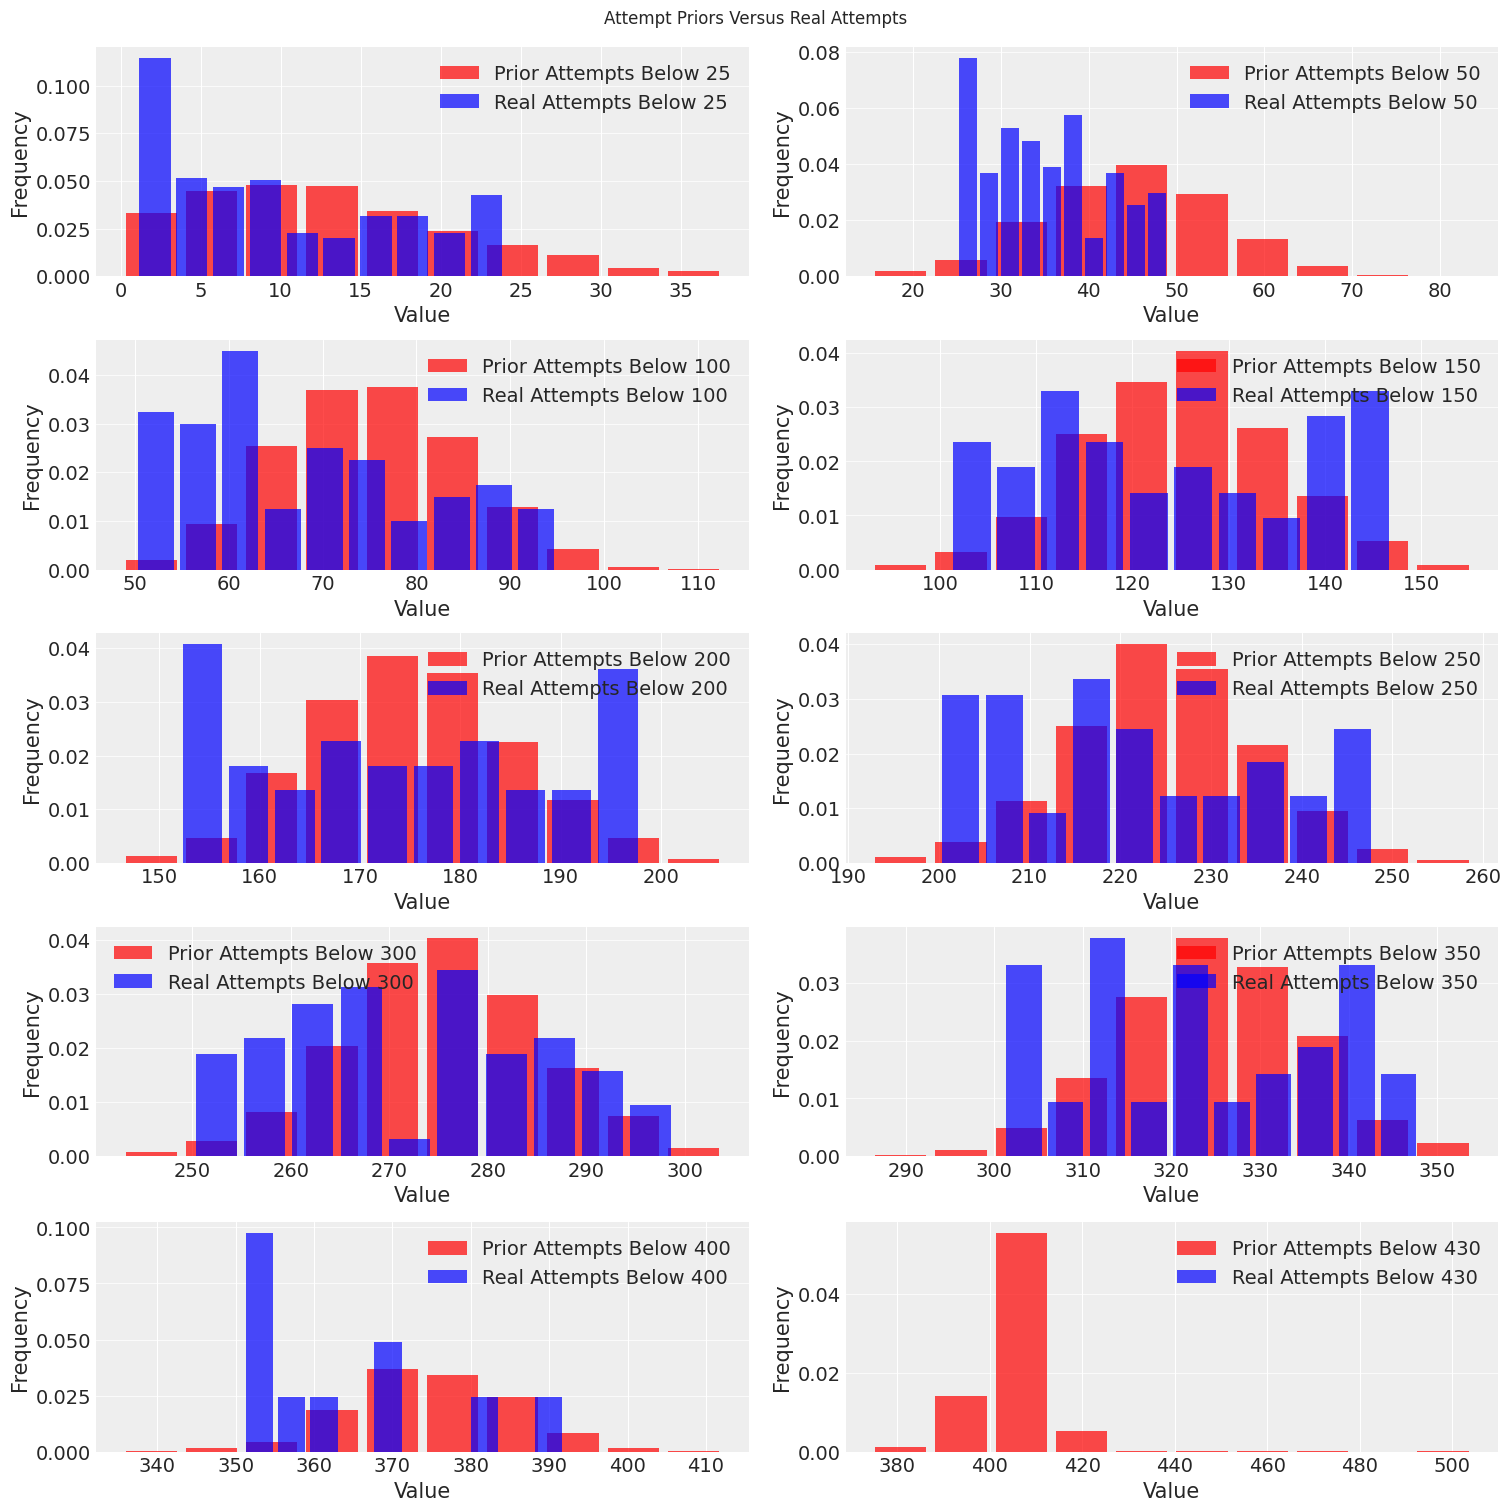

In [154]:

distributions = ['25_attempts',
                 '50_attempts',
                 '100_attempts',
                 '150_attempts',
                 '200_attempts',
                 '250_attempts',
                 '300_attempts',
                 '350_attempts',
                 '400_attempts',
                 'highest_attempts']



fig, ((ax1, ax2), 
      (ax3, ax4),
      (ax5, ax6),
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,15))

figures = [ax1,
           ax2,
           ax3,
           ax4,
           ax5,
           ax6,
           ax7,
           ax8,
           ax9,
           ax10]
rankings = [0, 
            25,
            50,
            100, 
            150,
            200,
            250,
            300,
            350,
            400,
            430]






fig.suptitle('Attempt Priors Versus Real Attempts')

for i in range(len(distributions)):

  predicted = trace_proper_attempts.posterior.data_vars[distributions[i]].values.tolist()[0]


  n, bins, patches = figures[i].hist(x=predicted, bins=10, color='red',
                            alpha=0.7, rwidth=0.85, label=f'Prior Attempts Below {rankings[i + 1]}', density=True)
  
  n, bins, patches = figures[i].hist(x=data[(data.Attempts < rankings[i+1]) & (data.Attempts >= rankings[i])]['Attempts'], 
                            bins=10, color='blue',
                            alpha=0.7, rwidth=0.85, 
                            label=f'Real Attempts Below {rankings[i + 1]}', density=True)
  figures[i].grid(axis='y', alpha=0.75)
  figures[i].set_xlabel('Value')
  figures[i].set_ylabel('Frequency')
  maxfreq = n.max()
  figures[i].legend()







## Prior Analysis

We can see that our priors do a decent job at modeling the real attempts. As expected, they still experience a hard time modeling the upper echelon of players due to the inherent variable play.

Our next step is using these distributions to model the potential attempts for a player in the following year. We do this using the below function and save the information in an array.

In [161]:
import random

samples = trace_proper_attempts.posterior


### Posterior versus prior - generate the prior distribution separately 
## 

bayes_attempt_predictions = []


for i in range(len(data)):
    # if person.iloc[0, 1] == 'QB':
    rank = data.iloc[i, 26]

    if rank == 0:
      dist = random.choice(samples.data_vars['25_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 1:
      dist = random.choice(samples.data_vars['50_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 2:
      dist = random.choice(samples.data_vars['100_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 3:
      dist = random.choice(samples.data_vars['150_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 4:
      dist = random.choice(samples.data_vars['200_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 5:
      dist = random.choice(samples.data_vars['250_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 6:
      dist = random.choice(samples.data_vars['300_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 7:
      dist = random.choice(samples.data_vars['350_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)
    elif rank == 8:
      dist = random.choice(samples.data_vars['400_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)

    elif rank == 9:
      dist = random.choice(samples.data_vars['highest_attempts'].values.tolist()[0])
      bayes_attempt_predictions.append(dist)

## Posterior of Attempts

It is important to check the posterior distribution of attempts. We do this by comparing the projected attempts for each player to their real attempts in the following graph. 

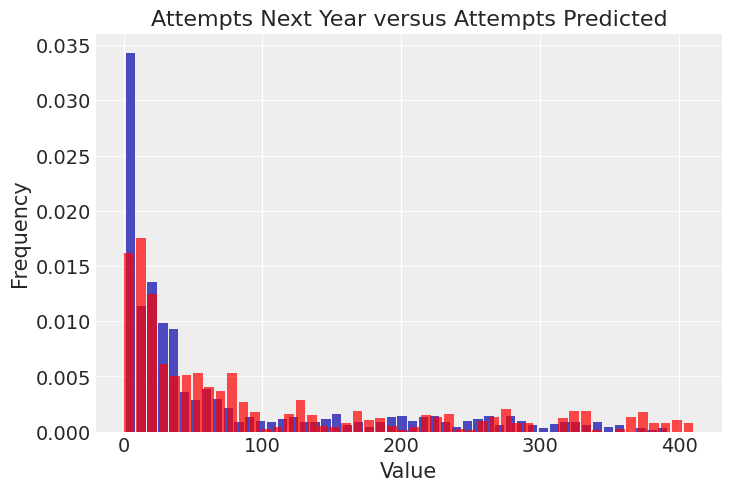

In [162]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=data['Attempts Next Year'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85, density=True)
n, bins, patches = plt.hist(x=bayes_attempt_predictions, bins=50, color='red',
                            alpha=0.7, rwidth=0.85, density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Attempts Next Year versus Attempts Predicted')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.



## Posterior Analysis

This is looking pretty nice! Let's use it to predict more!


## Touch Downs, Yards, and Fumbles

The following models will all be using bounded normals to predict each of their relative variables for each ranking group we previously described. We will also be using Metropolis-Hastings in our sampling.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [415_attempts, 400_attempts, 375_attempts, 350_attempts, 300_attempts, 250_attempts, 200_attempts, 150_attempts, 100_attempts, 50_attempts, 25_attempts]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%
25_attempts    1.633  0.893   0.022    3.117
50_attempts    2.785  1.634   0.034    5.537
100_attempts   3.706  1.873   0.001    6.711
150_attempts   4.699  1.968   0.891    8.348
200_attempts   5.648  1.943   1.854    9.116
250_attempts   6.481  1.945   2.488    9.885
300_attempts   7.307  1.981   3.474   10.814
350_attempts   8.143  2.029   4.373   11.982
375_attempts   8.479  2.028   4.694   12.301
400_attempts   8.887  2.012   5.255   12.894
415_attempts  12.016  2.071   8.187   15.818

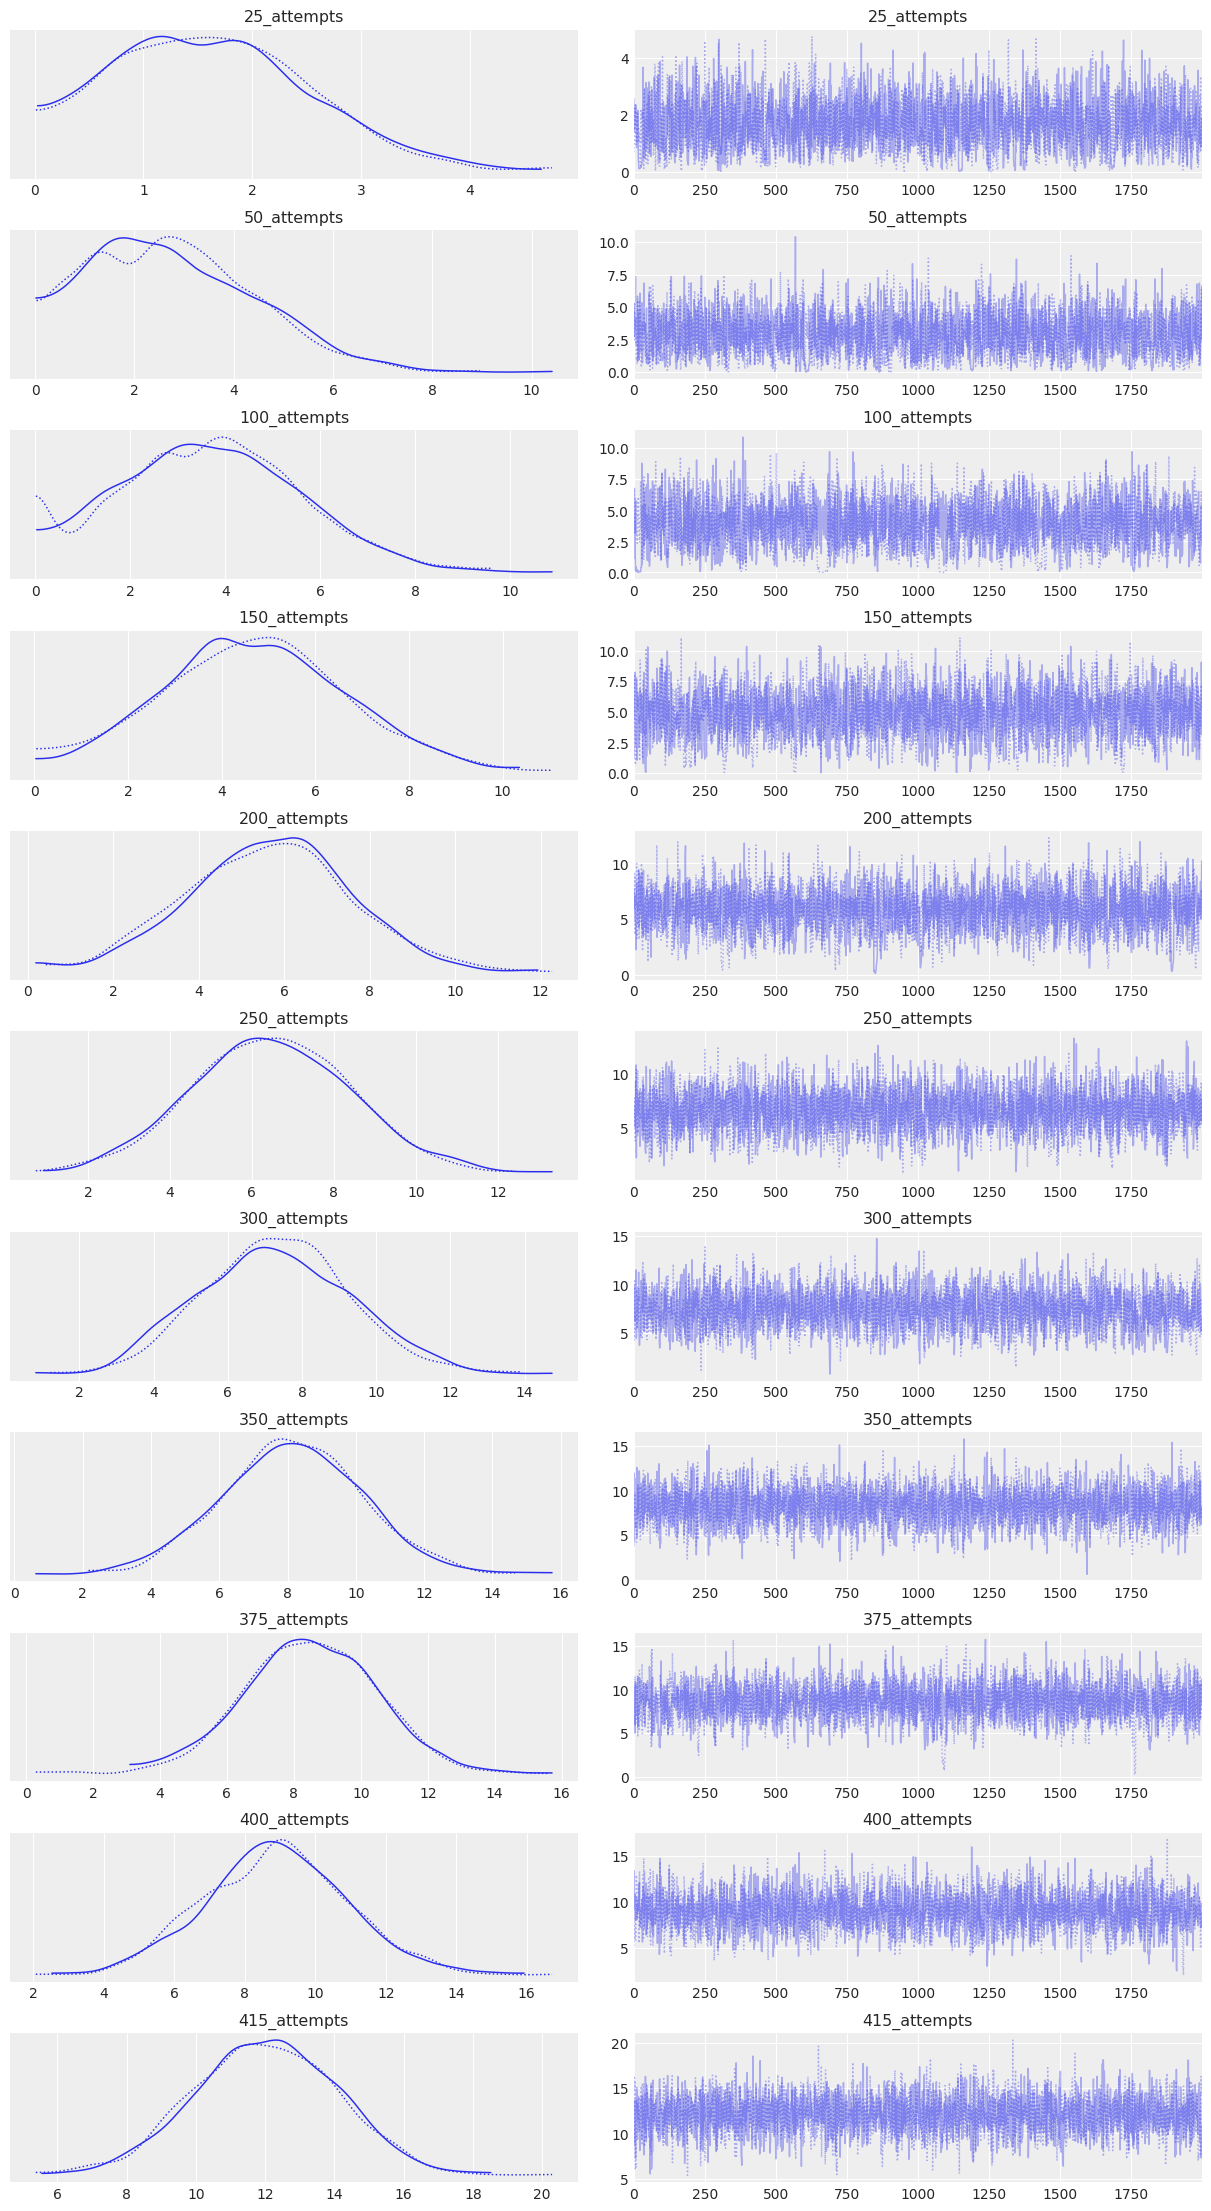

In [163]:
with pm.Model() as TD_model: 


  BoundedNormal = pm.Bound(pm.Normal, lower=0.0)

  # 25
  mu = 25**.65 * .18
  sigma = 1
  twenty_five = BoundedNormal("25_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  # 50

  mu = 50**.65 * .18
  sigma = 2
  fifty = BoundedNormal("50_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  # 100
  mu = 100**.65 * .18
  sigma = 2
  one_hundred = BoundedNormal("100_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  #150
  mu = 150**.65 * .18
  sigma = 2
  o = BoundedNormal("150_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  # 200
  mu = 200**.65 * .18
  sigma = 2
  j = BoundedNormal("200_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  # 250
  mu = 250**.65 * .18
  sigma = 2
  d = BoundedNormal("250_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  # 300
  mu = 300**.65 * .18
  sigma = 2
  d = BoundedNormal("300_attempts",
                       mu=mu,
                       sigma= sigma,
                       )

  # 350
  mu = 350**.65 * .18
  sigma = 2

  d = BoundedNormal("350_attempts",
                    mu=mu,
                    sigma= sigma,
                    )


  # 375
  mu = 375**.65 * .18
  sigma = 2

  d = BoundedNormal("375_attempts",
                    mu=mu,
                    sigma= sigma,
                    )


  # 400
  mu = 400**.65 * .18
  sigma = 2

  d = BoundedNormal("400_attempts",
                      mu=mu,
                      sigma= sigma,
                      )

  # 415
  mu = 12
  sigma = 2
  d = BoundedNormal("415_attempts", mu=mu,
                    sigma= sigma,
                    )




  step = pm.Metropolis()
  trace_TD = pm.sample(2000, chains=2, return_inferencedata=True) #, step=step)
  az.plot_trace(trace_TD)

az.summary(trace_TD, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [highest_attempts, 400_attempts, 350_attempts, 300_attempts, 250_attempts, 200_attempts, 150_attempts, 100_attempts, 50_attempts]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.


mean     sd  hdi_3%  hdi_97%
25_attempts    1.633  0.893   0.022    3.117
50_attempts    2.785  1.634   0.034    5.537
100_attempts   3.706  1.873   0.001    6.711
150_attempts   4.699  1.968   0.891    8.348
200_attempts   5.648  1.943   1.854    9.116
250_attempts   6.481  1.945   2.488    9.885
300_attempts   7.307  1.981   3.474   10.814
350_attempts   8.143  2.029   4.373   11.982
375_attempts   8.479  2.028   4.694   12.301
400_attempts   8.887  2.012   5.255   12.894
415_attempts  12.016  2.071   8.187   15.818

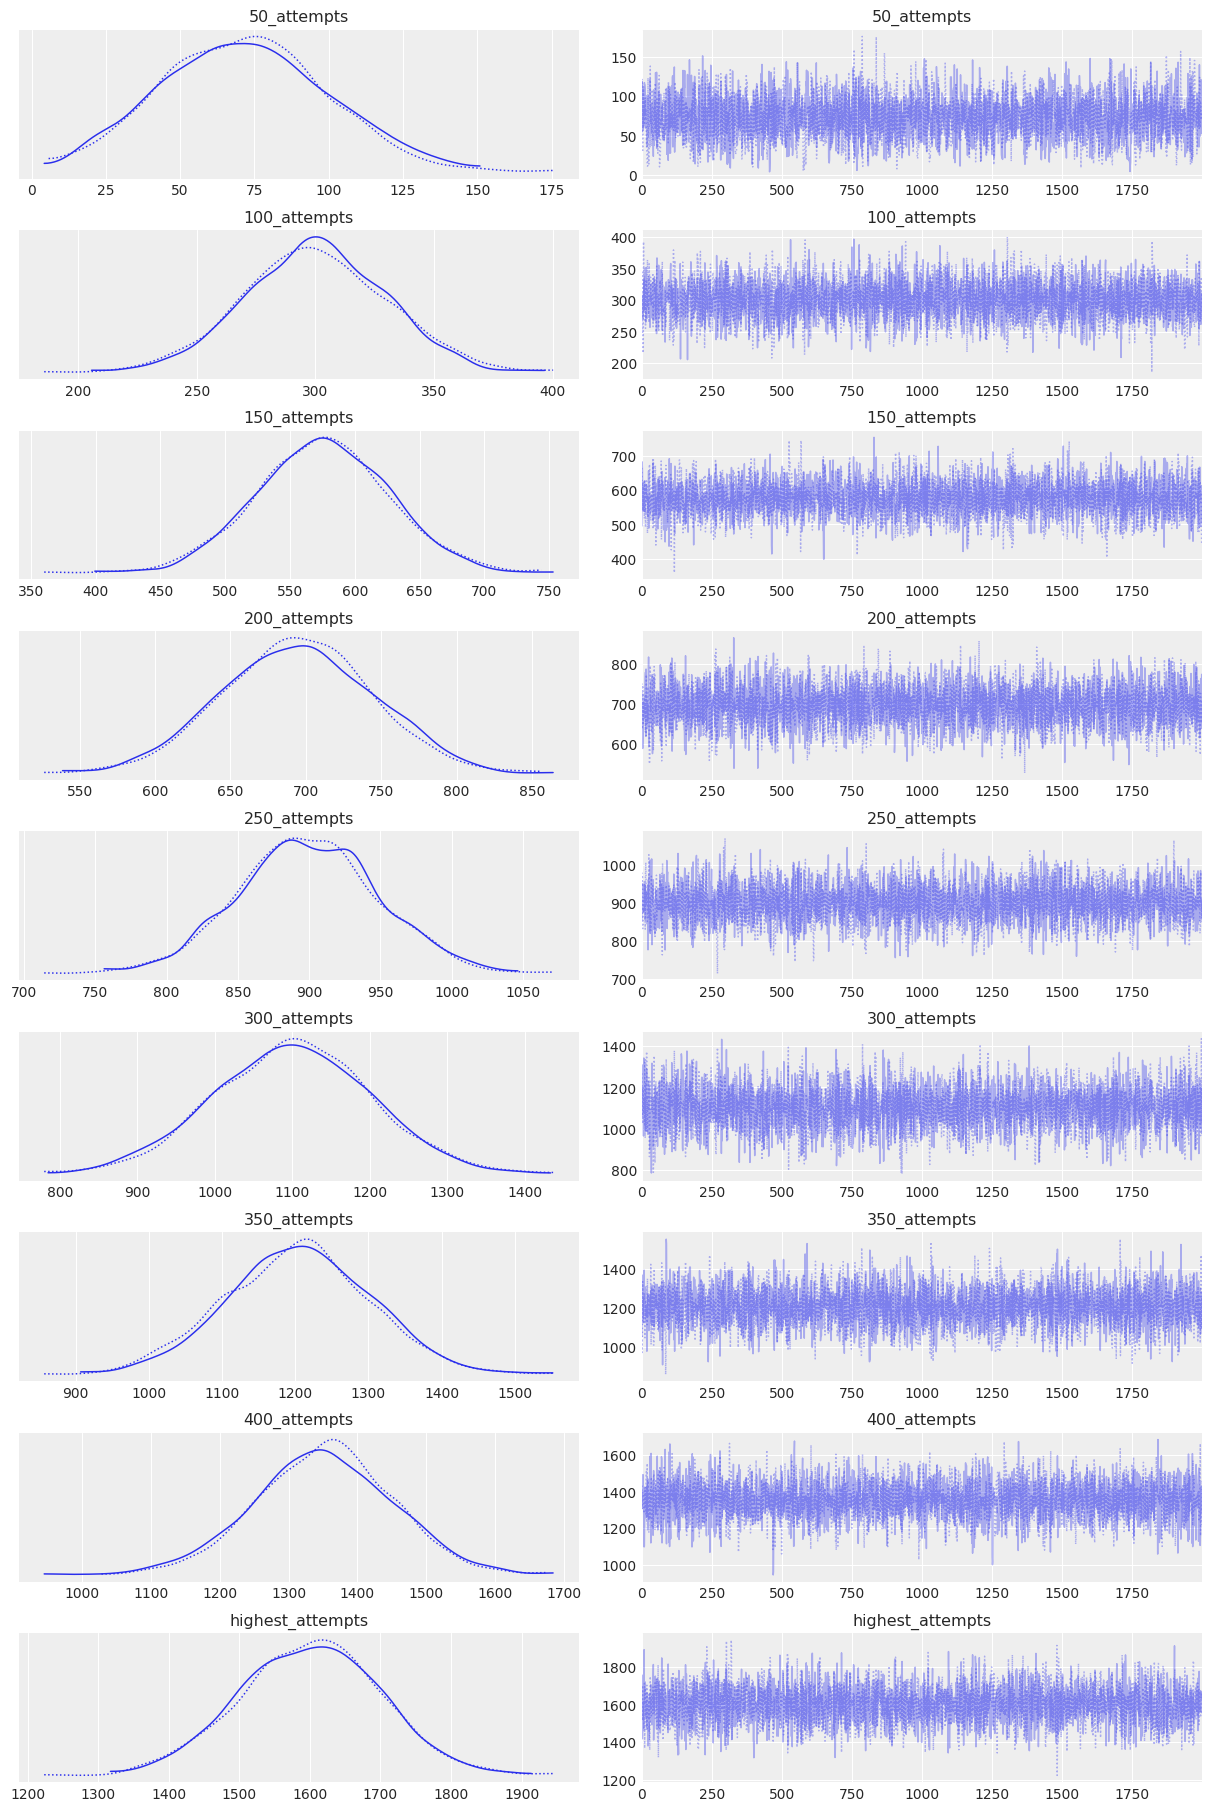

In [164]:
with pm.Model() as yard_model:

  # under 50



  mu = 70
  sigma = 30

  d = BoundedNormal("50_attempts",
                    mu=mu,
                    sigma= sigma,
                    )

  #50 to 100

  mu = 300
  sigma = 30
  d = BoundedNormal("100_attempts",
                    mu=mu,
                    sigma= sigma,
                    )

  # 100 to 150

  mu = 575
  sigma = 50
  d = BoundedNormal("150_attempts",
                    mu=mu,
                    sigma= sigma,
                    ) 
  #150 to 200

  mu = 695
  sigma = 50
  d = BoundedNormal("200_attempts",
                    mu=mu,
                    sigma= sigma,
                    ) 
  #200 to 250

  mu = 900
  sigma = 50
  d = BoundedNormal("250_attempts",
                    mu=mu,
                    sigma= sigma,
                    ) 



  #250 to 300 

  mu = 1100
  sigma = 100
  d = BoundedNormal("300_attempts",
                    mu=mu,
                    sigma= sigma,
                    ) 



  # 300 to 350

  mu = 1200
  sigma = 100

  d = BoundedNormal("350_attempts",
                    mu=mu,
                    sigma= sigma,
                    ) 
  
  mu = 1350
  sigma = 100

  d = BoundedNormal("400_attempts", mu=mu, sigma=sigma)



  # 400+

  mu = 1600
  sigma = 100
  d = BoundedNormal("highest_attempts",
                    mu=mu,
                    sigma= sigma,
                    ) 

  step = pm.Metropolis()
  trace_yards = pm.sample(2000, chains=2, return_inferencedata=True) #, step=step)
  az.plot_trace(trace_yards)

az.summary(trace_TD, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [fumbles_regular, QB_fumbles]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.


mean     sd  hdi_3%  hdi_97%
QB_fumbles       9.010  2.037   5.139   12.719
fumbles_regular  4.974  1.032   3.095    6.896

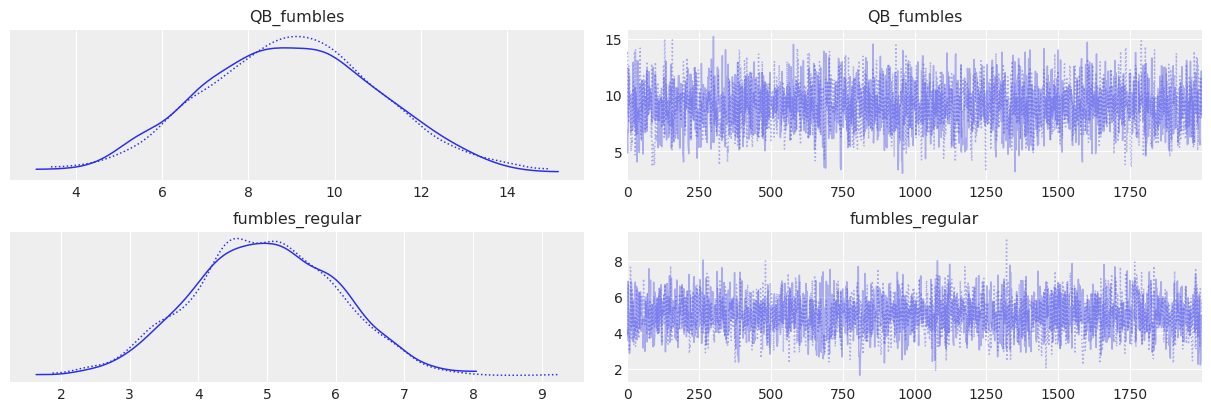

In [165]:
with pm.Model() as fumble_model:


  mu = 9
  sigma = 2

  v = BoundedNormal('QB_fumbles', mu, sigma)

  fumbles = BoundedNormal('fumbles_regular', 5, 1)

  step = pm.Metropolis()
  trace_fumbles = pm.sample(2000, chains=2, return_inferencedata=True) #, step=step)
  az.plot_trace(trace_fumbles)



az.summary(trace_fumbles, kind="stats") 

## Prior Checks for TDs, Yards, and Fumbles

Everything looks to be converging well! Let's do some prior distribution checks!

##Touch Downs

AxesSubplot(0.125,0.749828;0.352273x0.130172)
AxesSubplot(0.547727,0.749828;0.352273x0.130172)
AxesSubplot(0.125,0.593621;0.352273x0.130172)
AxesSubplot(0.547727,0.593621;0.352273x0.130172)
AxesSubplot(0.125,0.437414;0.352273x0.130172)
AxesSubplot(0.547727,0.437414;0.352273x0.130172)
AxesSubplot(0.125,0.281207;0.352273x0.130172)
AxesSubplot(0.547727,0.281207;0.352273x0.130172)
AxesSubplot(0.125,0.125;0.352273x0.130172)
AxesSubplot(0.547727,0.125;0.352273x0.130172)


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


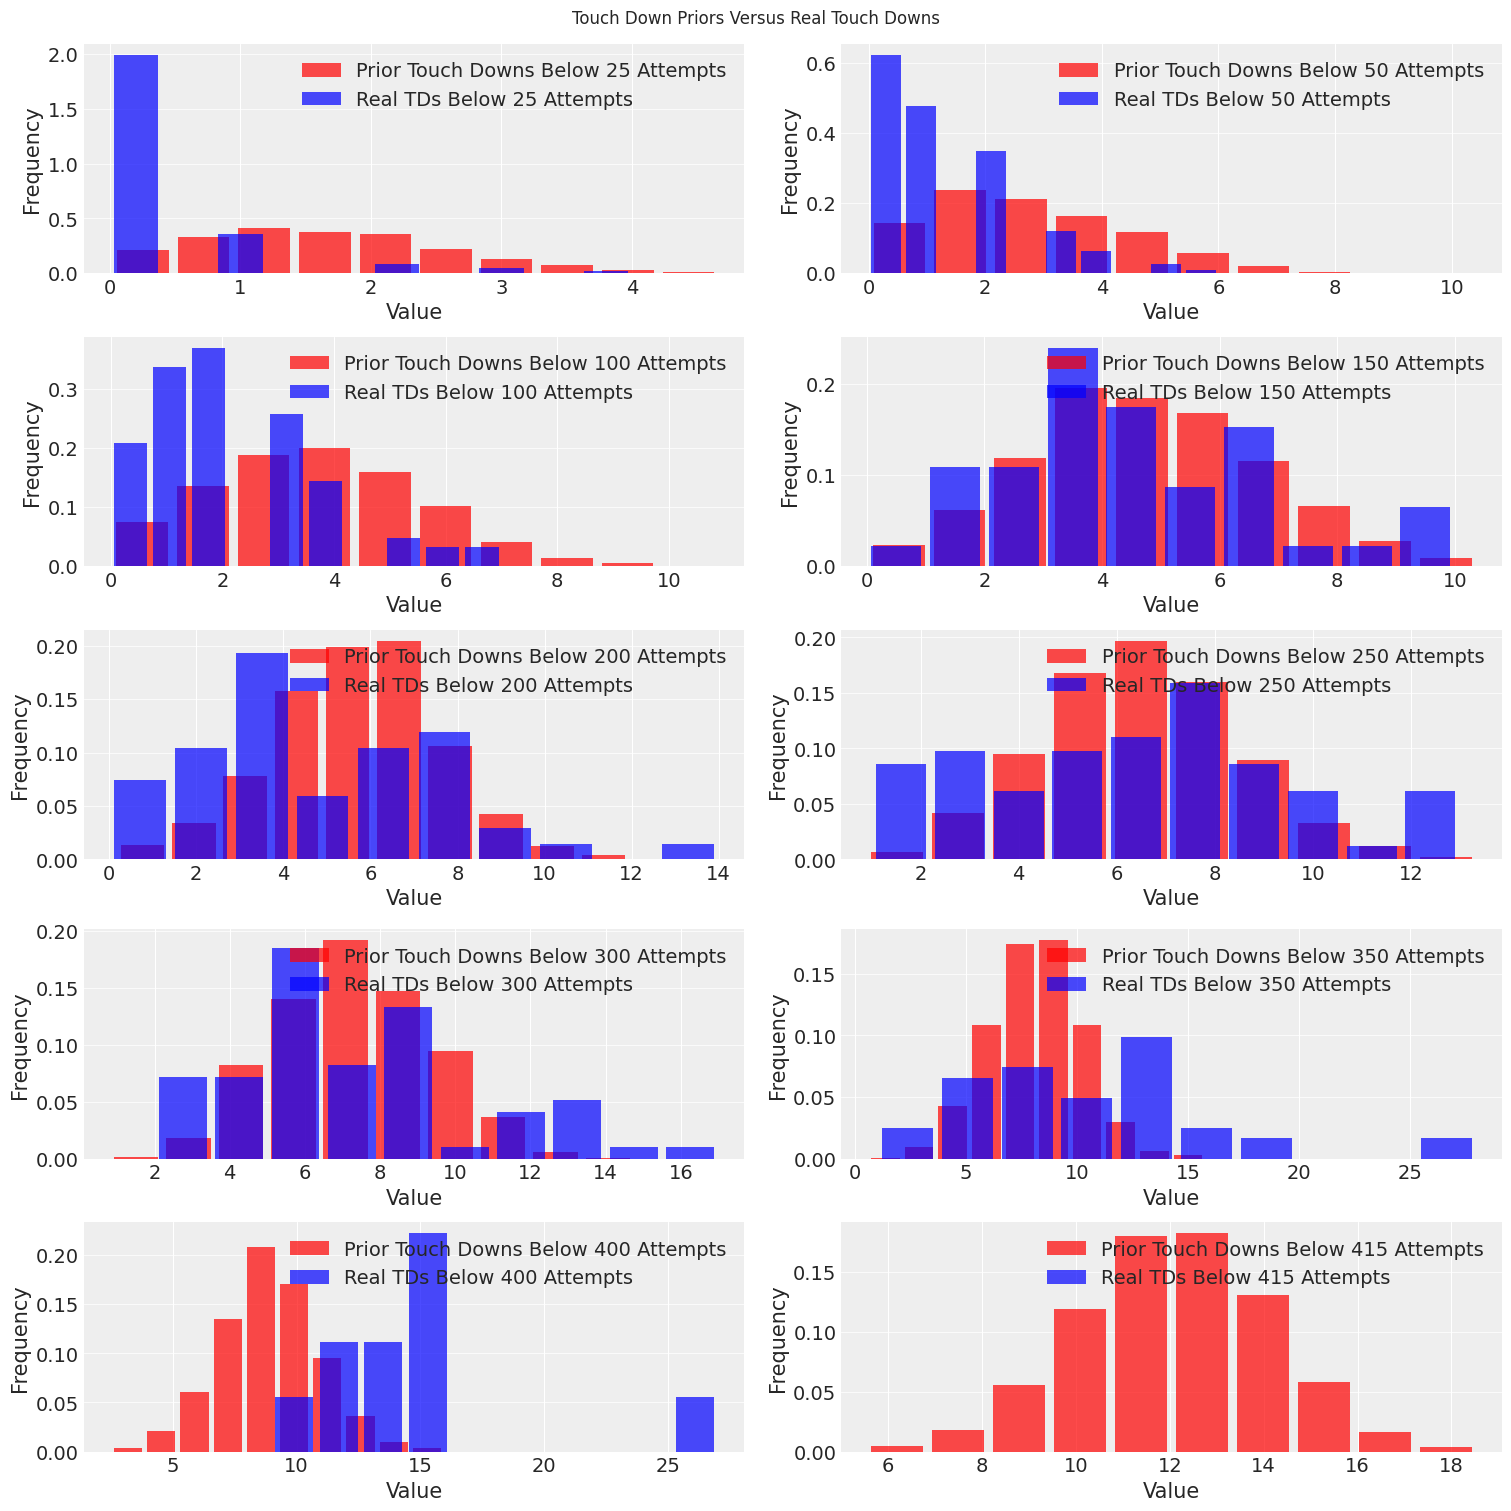

In [166]:
distributions = ['25_attempts',
                 '50_attempts',
                 '100_attempts',
                 '150_attempts',
                 '200_attempts',
                 '250_attempts',
                 '300_attempts',
                 '350_attempts',
                 '400_attempts',
                 '415_attempts']



fig, ((ax1, ax2), 
      (ax3, ax4),
      (ax5, ax6),
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,15))

figures = [ax1,
           ax2,
           ax3,
           ax4,
           ax5,
           ax6,
           ax7,
           ax8,
           ax9,
           ax10]
rankings = [0, 
            25,
            50,
            100, 
            150,
            200,
            250,
            300,
            350,
            400,
            415]






fig.suptitle('Touch Down Priors Versus Real Touch Downs')

for i in range(len(distributions)):
  print(figures[i])
  n, bins, patches = figures[i].hist(x=trace_TD.posterior.data_vars[distributions[i]].values.tolist()[0], bins=10, color='red',
                            alpha=0.7, rwidth=0.85, label=f'Prior Touch Downs Below {rankings[i + 1]} Attempts', density=True)
  
  n, bins, patches = figures[i].hist(x=data[(data.Attempts < rankings[i+1]) & (data.Attempts >= rankings[i])]['TD'], 
                            bins=10, color='blue',
                            alpha=0.7, rwidth=0.85, 
                            label=f'Real TDs Below {rankings[i + 1]} Attempts', density=True)
  figures[i].grid(axis='y', alpha=0.75)
  figures[i].set_xlabel('Value')
  figures[i].set_ylabel('Frequency')
  maxfreq = n.max()
  figures[i].legend()

##Yards

AxesSubplot(0.125,0.749828;0.352273x0.130172)
AxesSubplot(0.547727,0.749828;0.352273x0.130172)
AxesSubplot(0.125,0.593621;0.352273x0.130172)
AxesSubplot(0.547727,0.593621;0.352273x0.130172)
AxesSubplot(0.125,0.437414;0.352273x0.130172)
AxesSubplot(0.547727,0.437414;0.352273x0.130172)
AxesSubplot(0.125,0.281207;0.352273x0.130172)
AxesSubplot(0.547727,0.281207;0.352273x0.130172)
AxesSubplot(0.125,0.125;0.352273x0.130172)
AxesSubplot(0.547727,0.125;0.352273x0.130172)


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


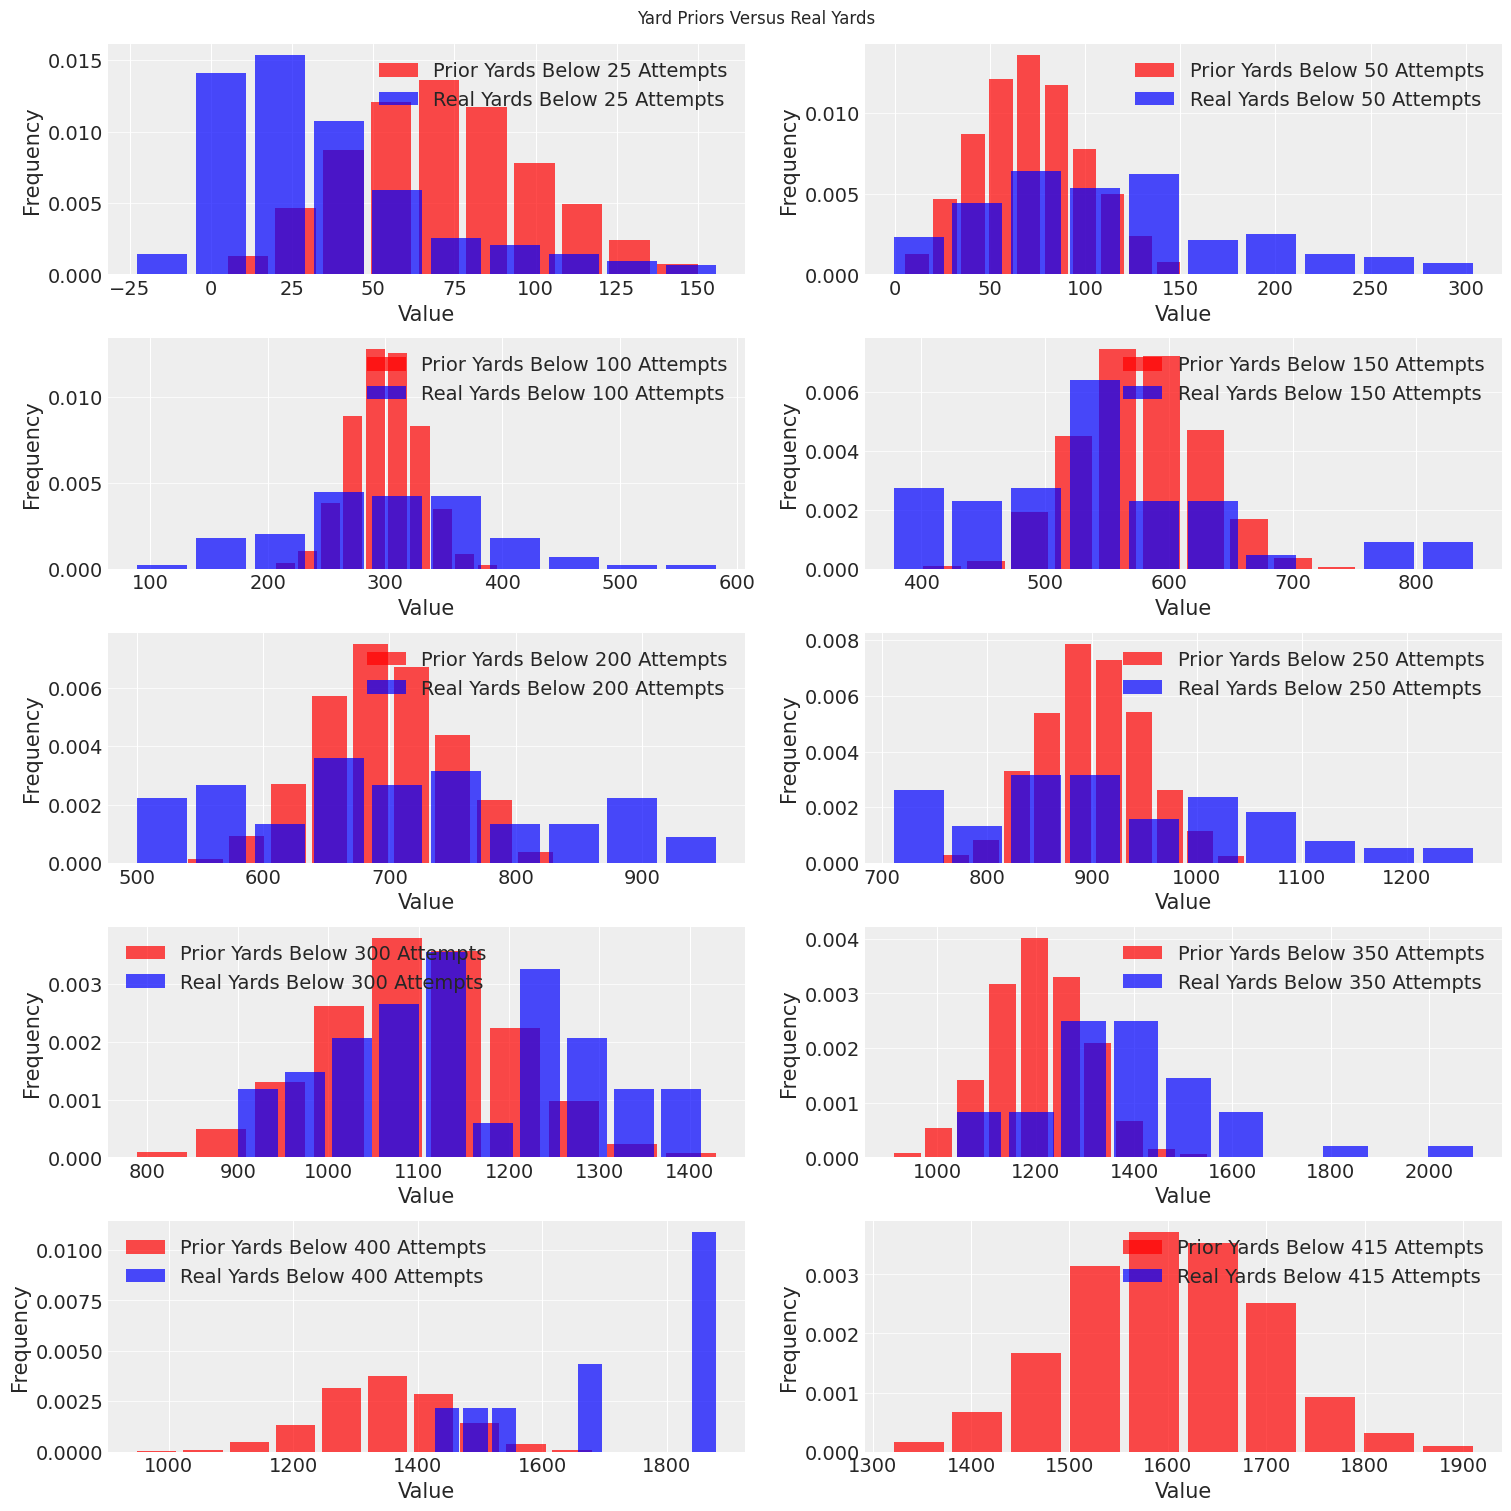

In [167]:
distributions = ['50_attempts',
                 '50_attempts',
                 '100_attempts',
                 '150_attempts',
                 '200_attempts',
                 '250_attempts',
                 '300_attempts',
                 '350_attempts',
                 '400_attempts',
                 'highest_attempts']



fig, ((ax1, ax2), 
      (ax3, ax4),
      (ax5, ax6),
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,15))

figures = [ax1,
           ax2,
           ax3,
           ax4,
           ax5,
           ax6,
           ax7,
           ax8,
           ax9,
           ax10]
rankings = [0, 
            25,
            50,
            100, 
            150,
            200,
            250,
            300,
            350,
            400,
            415]






fig.suptitle('Yard Priors Versus Real Yards')

for i in range(len(distributions)):
  print(figures[i])
  n, bins, patches = figures[i].hist(x=trace_yards.posterior.data_vars[distributions[i]].values.tolist()[0], bins=10, color='red',
                            alpha=0.7, rwidth=0.85, label=f'Prior Yards Below {rankings[i + 1]} Attempts', density=True)
  
  n, bins, patches = figures[i].hist(x=data[(data.Attempts < rankings[i+1]) & (data.Attempts >= rankings[i])]['Yards'], 
                            bins=10, color='blue',
                            alpha=0.7, rwidth=0.85, 
                            label=f'Real Yards Below {rankings[i + 1]} Attempts', density=True)
  figures[i].grid(axis='y', alpha=0.75)
  figures[i].set_xlabel('Value')
  figures[i].set_ylabel('Frequency')
  maxfreq = n.max()
  figures[i].legend()

## Fumbles

AxesSubplot(0.125,0.749828;0.352273x0.130172)
AxesSubplot(0.547727,0.749828;0.352273x0.130172)
AxesSubplot(0.125,0.593621;0.352273x0.130172)
AxesSubplot(0.547727,0.593621;0.352273x0.130172)
AxesSubplot(0.125,0.437414;0.352273x0.130172)
AxesSubplot(0.547727,0.437414;0.352273x0.130172)
AxesSubplot(0.125,0.281207;0.352273x0.130172)
AxesSubplot(0.547727,0.281207;0.352273x0.130172)
AxesSubplot(0.125,0.125;0.352273x0.130172)
AxesSubplot(0.547727,0.125;0.352273x0.130172)


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


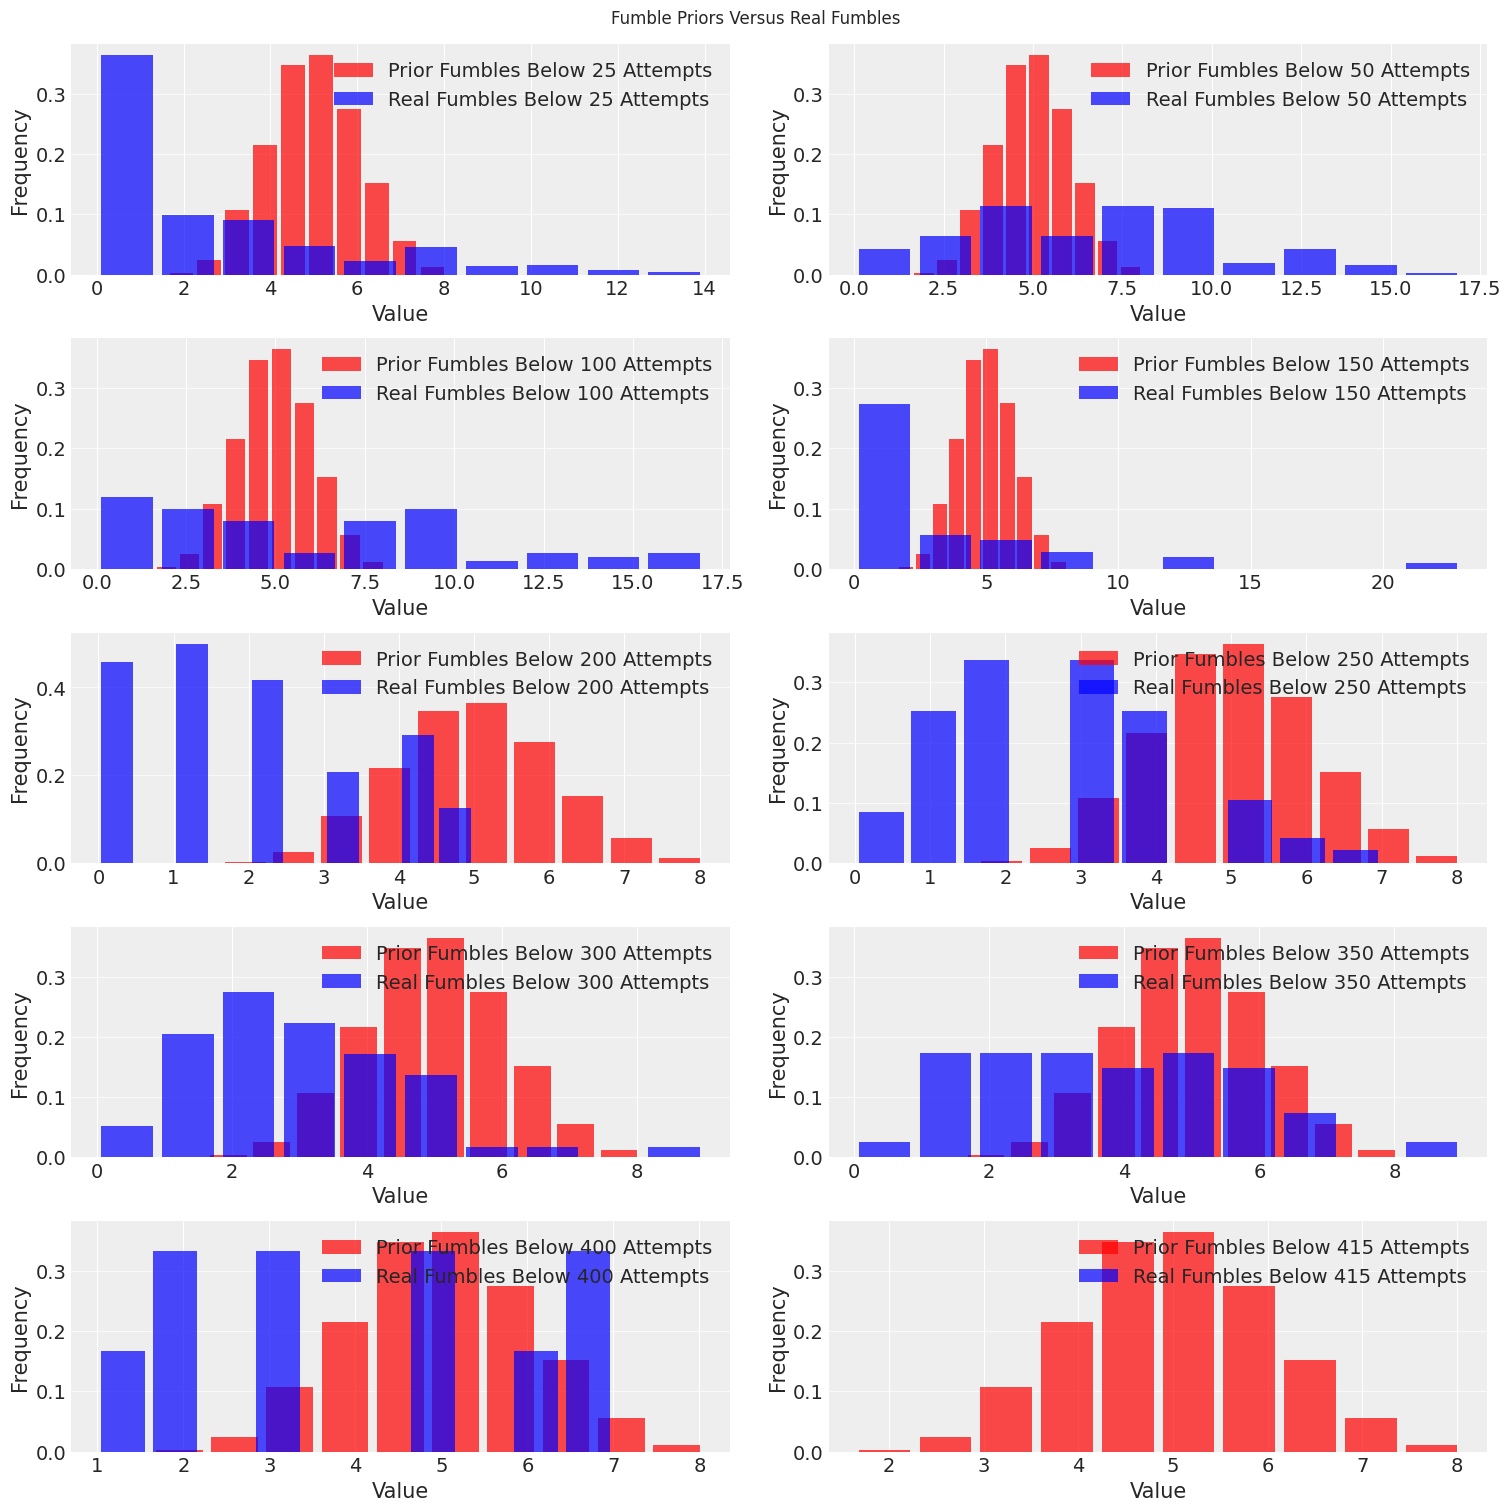

In [168]:
distributions = ['fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular',
                 'fumbles_regular']



fig, ((ax1, ax2), 
      (ax3, ax4),
      (ax5, ax6),
      (ax7, ax8),
      (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,15))

figures = [ax1,
           ax2,
           ax3,
           ax4,
           ax5,
           ax6,
           ax7,
           ax8,
           ax9,
           ax10]
rankings = [0, 
            25,
            50,
            100, 
            150,
            200,
            250,
            300,
            350,
            400,
            415]






fig.suptitle('Fumble Priors Versus Real Fumbles')

for i in range(len(distributions)):
  print(figures[i])
  n, bins, patches = figures[i].hist(x=trace_fumbles.posterior.data_vars[distributions[i]].values.tolist()[0], bins=10, color='red',
                            alpha=0.7, rwidth=0.85, label=f'Prior Fumbles Below {rankings[i + 1]} Attempts', density=True)
  
  n, bins, patches = figures[i].hist(x=data[(data.Attempts < rankings[i+1]) & (data.Attempts >= rankings[i])]['Fumbles'], 
                            bins=10, color='blue',
                            alpha=0.7, rwidth=0.85, 
                            label=f'Real Fumbles Below {rankings[i + 1]} Attempts', density=True)
  figures[i].grid(axis='y', alpha=0.75)
  figures[i].set_xlabel('Value')
  figures[i].set_ylabel('Frequency')
  maxfreq = n.max()
  figures[i].legend()

##Priors are matching up well! With more time they can be tweaked. 

Let's use these to project points!

First we need to clean up the positions because quarterbacks are an outlier on fumbles!

In [169]:
def clean_position(posit):

  posit = posit.upper()
  posit = posit.replace("/", '')

  return posit

data['cleaned_position'] = data['Position'].apply(clean_position)

In [171]:
import random


# attempts = attempt_predictions
attempts = bayes_attempt_predictions

person = data[['Player', 'cleaned_position', 'Year', 'Yards',	'TD', 'Fumbles']]

points_next_year = data['Points Next Year']

TD = trace_TD
yard = trace_yards
fumble = trace_fumbles

yard_predictions = []
td_predictions = []

fumble_predictions = []

print(len(attempts))
print(len(person))

point_predictions = []

for i in range(len(person)):


  attempt = attempts[i]

  # fumbles 

  if person.iloc[i, 1] == 'QB':
    f = random.choice(fumble.posterior.data_vars['QB_fumbles'].values.tolist()[0])
  else:
    f = random.choice(fumble.posterior.data_vars['fumbles_regular'].values.tolist()[0])


  if attempt < 25:
    td = random.choice(trace_TD.posterior.data_vars['25_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['50_attempts'].values.tolist()[0])
  elif attempt < 50:
    td = random.choice(trace_TD.posterior.data_vars['50_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['50_attempts'].values.tolist()[0])
  elif attempt < 100:
    td = random.choice(trace_TD.posterior.data_vars['100_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['100_attempts'].values.tolist()[0])
  elif attempt < 150:
    td = random.choice(trace_TD.posterior.data_vars['150_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['150_attempts'].values.tolist()[0])
  elif attempt < 200:
    td = random.choice(trace_TD.posterior.data_vars['200_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['200_attempts'].values.tolist()[0])
  elif attempt < 250:
    td = random.choice(trace_TD.posterior.data_vars['250_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['250_attempts'].values.tolist()[0])
  elif attempt < 300:
    td = random.choice(trace_TD.posterior.data_vars['300_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['300_attempts'].values.tolist()[0])
  elif attempt < 350:
    td = random.choice(trace_TD.posterior.data_vars['350_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['350_attempts'].values.tolist()[0])
  elif attempt < 400:
    td = random.choice(trace_TD.posterior.data_vars['400_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['400_attempts'].values.tolist()[0])
  else:
    td = random.choice(trace_TD.posterior.data_vars['415_attempts'].values.tolist()[0])
    y = random.choice(yard.posterior.data_vars['highest_attempts'].values.tolist()[0])

  # 6TD + 0.1Yards - 2*Fumbles
  yard_predictions.append(y)
  fumble_predictions.append(f)
  td_predictions.append(td)
  points = 6*td + .1*y - 2 * f

  point_predictions.append(points)

898
898


## Final Posterior Checks

We will be doing a posterior check for the overall points, the yards, the fumbles, and the touch downs!

In [172]:
analysis = person
analysis['yard_prediction'] = yard_predictions
analysis['fumble_predictions'] = fumble_predictions
analysis['td_predictions'] = td_predictions
analysis['target_points'] = points_next_year
analysis['predicted_points'] = point_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

## Overall Point Performance

We can see from the below graph that the overall point performace wasn't too bad. Projecting the upper echelon of players was a bit hard but we will see how well we do when comparing our player choice to that of a greedy algorithm.

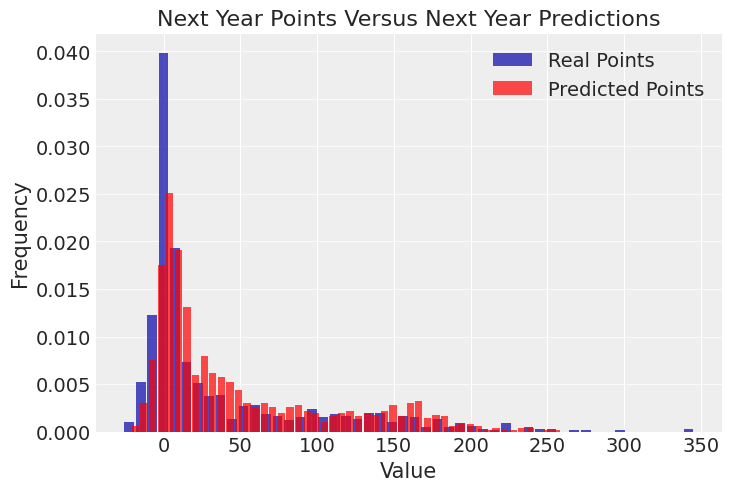

In [173]:
## the overall performance

n, bins, patches = plt.hist(x=analysis['target_points'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85, label='Real Points', density=True)
n, bins, patches = plt.hist(x=analysis['predicted_points'], bins=50, color='red',
                            alpha=0.7, rwidth=0.85, label='Predicted Points', density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Next Year Points Versus Next Year Predictions')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.legend()


## Touch Down Performance



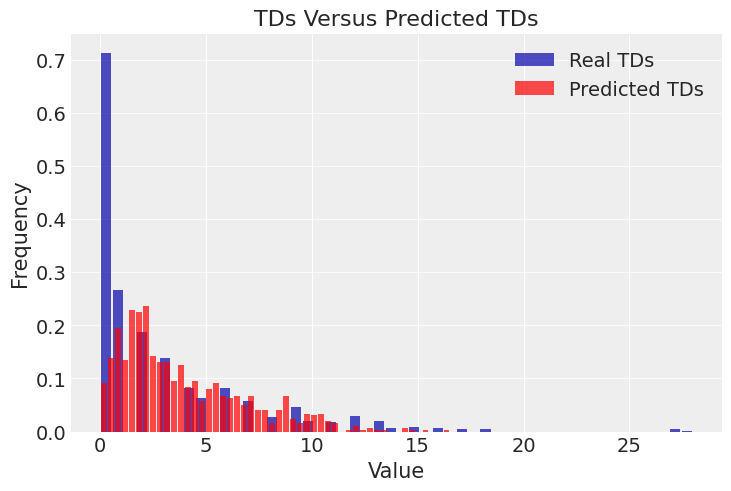

In [174]:
### TD Performance

n, bins, patches = plt.hist(x=analysis['TD'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85,label='Real TDs', density=True)
n, bins, patches = plt.hist(x=analysis['td_predictions'], bins=50, color='red',
                            alpha=0.7, rwidth=0.85,label='Predicted TDs', density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('TDs Versus Predicted TDs')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.legend()

## Yard Performance

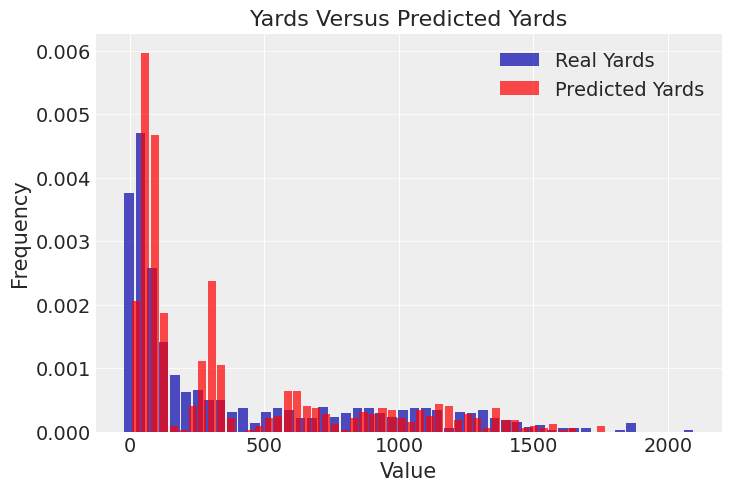

In [175]:

n, bins, patches = plt.hist(x=analysis['Yards'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85,label='Real Yards', density=True)
n, bins, patches = plt.hist(x=analysis['yard_prediction'], bins=50, color='red',
                            alpha=0.7, rwidth=0.85, density=True, label='Predicted Yards')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Yards Versus Predicted Yards')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.legend()

## Fumble Performance

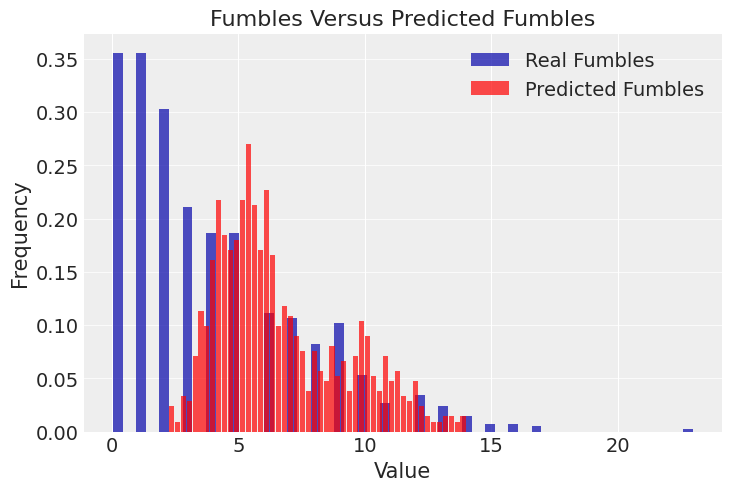

In [176]:
n, bins, patches = plt.hist(x=analysis['Fumbles'], bins=50, color='#0504aa',
                            alpha=0.7, rwidth=0.85, label='Real Fumbles', density=True)
n, bins, patches = plt.hist(x=analysis['fumble_predictions'], bins=50, color='red',
                            alpha=0.7, rwidth=0.85, label='Predicted Fumbles', density=True)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Fumbles Versus Predicted Fumbles')
# plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.legend()

## Posterior Analysis

Overall the posterior doing a decent job at predicting the overall point distribution. Fumbles are doing the least well but they account for such a small part of the point function that they are not influencing the total outcome much.

## Using the Algorithm

There are a couple ways we can test the accuracy of this model. We will be comparing the our model to a greedy algorithm. 



Greedy Algorithm

This greedy algorithm will act as our opponent. It will start by picking the proven best point players from the prior year and using them to pick the following year. 


We will be using our algorithm to pick the players we believe are the best. 

In [177]:
greedy_pick = data[['Player', 'Year', 'Points', 'Points Next Year']][data.Year == 2018].sort_values(by='Points', ascending=False)

In [178]:
year = 2018

predicted_top  = analysis[['Player', 'Year','predicted_points']][analysis.Year == year].sort_values(by='predicted_points', ascending=False)

In [179]:
### Lets pick first

def get_picks(greedy_pick, predicted_top):

  greedy_options = greedy_pick['Player'].tolist()
  our_options = predicted_top['Player'].tolist()

  our_draft = []
  greedy_draft = []

  ## Just i + 1

  for i in range(10):

    ## our pick
    opick = our_options[0]
    if opick not in greedy_draft:
      our_draft.append(opick)
      our_options.remove(opick)
    else:
      indraft = True
      count = 1
      while indraft == True:
        
        opick = our_options[count]
        if opick not in greedy_draft:
          our_draft.append(opick)
          our_options.remove(opick)
          indraft = False
        else:
          count += 1
    
    gpick = greedy_options[0]
    if opick not in our_draft:
      greedy_draft.append(gpick)
      greedy_options.remove(gpick)
    else:
      indraft = True
      count = 1
      while indraft == True:
        
        gpick = greedy_options[count]
        if gpick not in our_draft:
          greedy_draft.append(gpick)
          greedy_options.remove(gpick)
          indraft = False
        else:
          count += 1

  return  greedy_draft, our_draft
  
get_picks(greedy_pick, predicted_top)

(['Melvin Gordon',
  'Latavius Murray',
  'Frank Gore',
  'LeSean McCoy',
  'Cam Newton',
  'Bilal Powell',
  'Aaron Rodgers',
  'Blake Bortles',
  'Russell Wilson',
  'Ben Roethlisberger'],
 ['Ezekiel Elliott',
  'Jordan Howard',
  'Robert Woods',
  'Todd Gurley',
  'Dak Prescott',
  'Dion Lewis',
  'Marcus Mariota',
  'Jameis Winston',
  'Drew Brees',
  'Stefon Diggs'])

In [180]:
our_score = 0

our_draft = get_picks(greedy_pick, predicted_top)[1]
greedy_draft = get_picks(greedy_pick, predicted_top)[0]
comparison = data[data.Year == year]

for player in our_draft:
  player_row = comparison[comparison.Player == player]
  score = player_row['Points Next Year'].tolist()[0]
  # print(score)
  our_score += score

print("Our Score: ")
print(our_score)


greedy_score = 0

for player in greedy_draft:
  player_row = comparison[comparison.Player == player]
  score = player_row['Points Next Year'].tolist()[0]
  # print(score)
  greedy_score += score

print('Greedy Score: ')
print(greedy_score)

Our Score: 
529.6
Greedy Score: 
400.3


## Greedy Algorithm Comparison

We can see from above that our algorithm performed very well against the 2018 greedy picks. However, this might be cherry picking so let's see how it performs year over year. 

In [181]:
total_difference = 0
differences = []


for year in data['Year'].unique():
  greedy_pick = data[['Player', 'Year', 'Points', 'Points Next Year']][data.Year == year].sort_values(by='Points', ascending=False)
  predicted_top  = analysis[['Player', 'Year','predicted_points']][analysis.Year == year].sort_values(by='predicted_points', ascending=False)

  picks = get_picks(greedy_pick, predicted_top)

  our_score = 0

  comparison = data[data.Year == year]
  for player in picks[1]:
    player_row = comparison[comparison.Player == player]

    score = player_row['Points Next Year'].tolist()[0]
    # print(score)
    our_score += score

  


  greedy_score = 0

  for player in picks[0]:
    player_row = comparison[comparison.Player == player]
    score = player_row['Points Next Year'].tolist()[0]
    # print(score)
    greedy_score += score
  
  print(f'Our Score for {year}:')
  print(int(our_score))
  print(f'Greedy Score for {year}:')
  print(int(greedy_score))

  print('Point Difference:')

  print(int(our_score - greedy_score))

  total_difference += int(our_score - greedy_score)
  differences.append(int(our_score - greedy_score))

print("The total difference in points: ", total_difference)
print("The average loss: ", sum(differences) / len(differences))

Our Score for 2002:
798
Greedy Score for 2002:
1152
Point Difference:
-354
Our Score for 2003:
1310
Greedy Score for 2003:
1147
Point Difference:
162
Our Score for 2004:
1359
Greedy Score for 2004:
843
Point Difference:
515
Our Score for 2005:
700
Greedy Score for 2005:
1540
Point Difference:
-840
Our Score for 2006:
1166
Greedy Score for 2006:
720
Point Difference:
446
Our Score for 2007:
906
Greedy Score for 2007:
954
Point Difference:
-48
Our Score for 2008:
710
Greedy Score for 2008:
783
Point Difference:
-72
Our Score for 2009:
830
Greedy Score for 2009:
583
Point Difference:
246
Our Score for 2010:
853
Greedy Score for 2010:
984
Point Difference:
-131
Our Score for 2011:
859
Greedy Score for 2011:
919
Point Difference:
-60
Our Score for 2012:
876
Greedy Score for 2012:
1099
Point Difference:
-222
Our Score for 2013:
613
Greedy Score for 2013:
953
Point Difference:
-340
Our Score for 2014:
791
Greedy Score for 2014:
627
Point Difference:
163
Our Score for 2015:
414
Greedy Score fo

## Room For Improvement

We see from the above that we have an average loss of - 46.5 over all of the NFL seasons. This means there is room for improvement but we are not too far off. If your coworkers used a completely greedy algorithm you may win the complete pot sometimes. However, you will likely be one of the top point grossers for your group and some years you may even win. 